# This iPython notebook fits a simple offset to a data set ( y = x+b ) using MCMC fitting and least squares fitting. 
For the MCMC fitting two ways are used. The first way is with proper representation of the error bars (asymmetric gaussians and boxes with gaussian dropoffs).
Secondly, symmetrized errors are fitted. This should yield the same results as "standard" python least squares fitting which is done after.

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy import stats

import csv
from scipy.optimize import curve_fit
import pandas as pd
import pylab as pl
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib as mpl

# These defaults are the ones I like, but feel free to adapt or delete them
sns.set_style('white')
sns.set_context('talk')

## Define data points
Get data from .txt file

In [33]:
def coordinates(filename):
    data = np.genfromtxt(filename, skip_header=1)
    DM_meas = data[:,11]
    DM_low = data[:,6]
    DM_c = data[:,7]
    DM_up = data[:,8]
    sigma_low = data[:,9]
    sigma_up = data[:,10]
    age = data[:,12]
    method = data[:,13]
    DM_delta = data[:,14]
    avg_e = data[:,15]

    return DM_meas, DM_low, DM_c, DM_up, sigma_low, sigma_up, age, method, DM_delta, avg_e

In [34]:
DM_meas, DM_low, DM_c, DM_up, sigma_low, sigma_up, age, method, DM_delta, avg_e = coordinates("associated.txt")
avg_err = avg_e + DM_delta
x_matrix = np.transpose([DM_c,method])

## Define Bayesian prior and likelihood functions.
I have multiple likelihoods. (See probability_functions.ipynb)
I specify which coordinates need which likelihood function using an array for my y_coordinates. The 2nd index gives the appropriate likelihood function.

The **log_prior** returns where the walkers are allowed. The offset should be positive, because of the transposed fitting, here we fit for a negative offset. All other values are not allowed and therefore return -np.inf 

The **log_likelihood** returns the likelihood functions for each of the data points. i.e. how should the error bars be represented in this case.

The **log_posterior** returns if the walker is going in the correct direction.

In [35]:
def log_prior(theta):
    # sigma needs to be negative. Am fitting transposed bc of error bars are take on y-axis.
    if theta[0] <= 0:
        return 0
    else:
        return -np.inf

def log_likelihood(theta, x, y, e, sigma_B, DM_low, DM_c, DM_up,sigma_low, sigma_up,DM_delta):
    dy = y[:,0] - theta[0] - x
    mod_y = theta[0] + x
    DM_low = y[:,0] - DM_delta
    DM_up = y[:,0] + DM_delta
    
    A_low = (sigma_low/sigma_up)
    A_up = np.ones(len(y[:,0]))
    N = 1/((A_low/2.)+(A_up/2.))
    
    A_lbox = (np.sqrt(2.*np.pi)*sigma_low)/(DM_up - DM_low)
    A_ubox = (np.sqrt(2.*np.pi)*sigma_up)/(DM_up - DM_low)
    N_box = 1/((A_lbox/2.)+(A_ubox/2.)+1)
    logL1 = np.ones(len(y[:,0]))* -np.inf  
    
    ## Indices for the boxes
    ind_b = y[:,1] == 2  
    ind_box_low = np.logical_and(ind_b, (mod_y < DM_low))
    ind_box_up = np.logical_and(ind_b, (mod_y > DM_up))
    ind_box = np.logical_and(ind_b, np.logical_and(mod_y >= DM_low, mod_y <= DM_up))
    
    logL1[ind_box] = np.log(1/(DM_up[ind_box]-DM_low[ind_box])) + np.log(N_box[ind_box])     ## Tophat normalized
    logL1[ind_box_low] = -0.5 * np.log(2 * np.pi * sigma_low[ind_box_low] ** 2) - 0.5 * (dy[ind_box_low] / sigma_low[ind_box_low]) ** 2 + np.log(A_lbox[ind_box_low]) + np.log(N_box[ind_box_low])    ## LOwer Gaussian
    logL1[ind_box_up] = -0.5 * np.log(2 * np.pi * sigma_up[ind_box_up] ** 2) - 0.5 * (dy[ind_box_up] / sigma_up[ind_box_up]) ** 2 + np.log(A_ubox[ind_box_up]) + np.log(N_box[ind_box_up])     ## Upper Gaussian
    
    ind_gauss_low = np.logical_and(~ind_b, (mod_y < DM_c))
    ind_gauss_up = np.logical_and(~ind_b, (mod_y >= DM_c))
    logL1[ind_gauss_low] = -0.5 * np.log(2 * np.pi * sigma_low[ind_gauss_low] ** 2) - 0.5 * (dy[ind_gauss_low] / sigma_low[ind_gauss_low]) ** 2 + np.log(A_low[ind_gauss_low]) + np.log(N[ind_gauss_low]) ## Lower Gaussian
    logL1[ind_gauss_up]  = -0.5 * np.log(2 * np.pi * sigma_up[ind_gauss_up] ** 2) - 0.5 * (dy[ind_gauss_up] / sigma_up[ind_gauss_up]) ** 2 + np.log(A_up[ind_gauss_up]) + np.log(N[ind_gauss_up]) ## Upper Gaussian
    
#    logL2 = - 0.5 * np.log(2 * np.pi * sigma_B ** 2) - 0.5 * (dy / sigma_B) ** 2  ## added
    
    return np.sum(logL1)
#    return np.sum(np.logaddexp(logL1, logL2)) ## added intrinsic scatter

def log_posterior(theta, x, y, e, sigma_B, DM_low, DM_c, DM_up,sigma_low, sigma_up,DM_delta):

    return log_prior(theta) + log_likelihood(theta, x, y, e, sigma_B, DM_low, DM_c, DM_up,sigma_low, sigma_up,DM_delta )

## Do the MCMC

In [36]:
ndim = 1   # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nburn = 500  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
#np.random.seed(20)
starting_guesses = np.random.random((nwalkers, ndim)) #-20 + 20* np.random.random((nwalkers, ndim))
#print "HIER", starting_guesses

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[DM_meas, x_matrix, avg_e, 100, DM_low, DM_c, DM_up,sigma_low, sigma_up,DM_delta ])

sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
# To ckeck if any -infinity exist
print "len all", len(sample)
print "len all infinite", len(sample[np.isfinite(sample)])

/Users/samayrastraal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/samayrastraal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in divide


len all 30000
len all infinite 30000


## Show the distribution of the fit to the data.

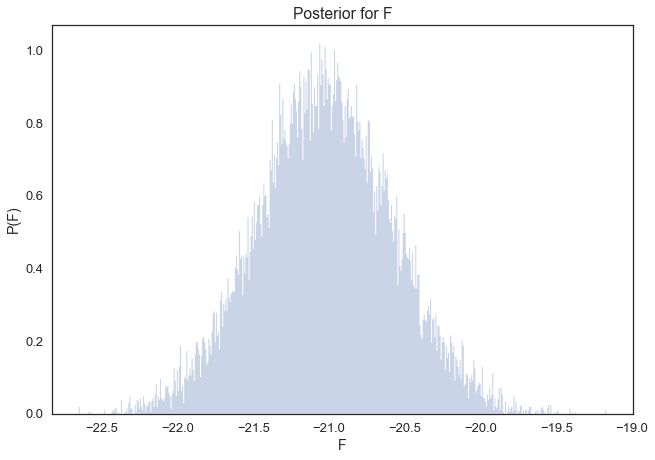

In [37]:
plt.hist(sample, bins=500, histtype="stepfilled", alpha=0.3, normed=True)
#plt.xlabel("theta"); plt.ylabel("PDF")
#F_fit = np.linspace(-23, -19, num=500)
#pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)
#plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")
plt.title('Posterior for F');

## Print the statistics on the fit

In [38]:

mean_associated = abs(np.mean(sample))
print "Mean is ", np.mean(sample)
print "Standard deviation is ", np.std(sample)

Mean is  -21.0270997453
Standard deviation is  0.445397172137


## Check the variation on the data

In [39]:
residu = DM_meas - DM_c + np.mean(sample)
#print residu
se = np.sum(residu**2)/np.sqrt(len(residu))
#print se
s = float(np.sqrt((1./(len(residu)-1.)*np.sum(residu**2))))
print float(1./17)
print 21.035/np.sqrt(18.)

0.0588235294118
4.95799704742


## Check if walkers converged:

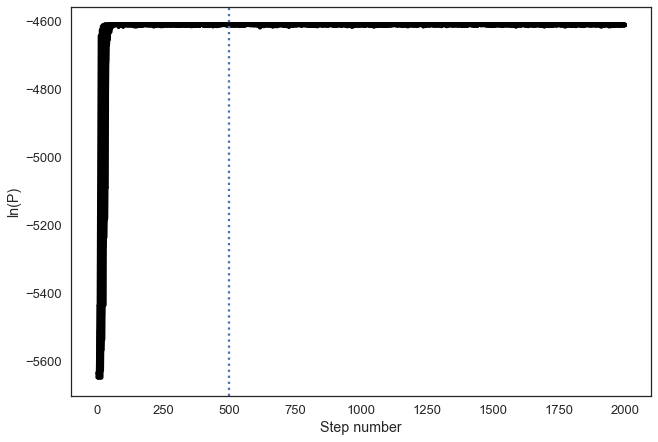

In [40]:
# sampler.lnprobability gives the log probability of the points in tha sampler. THe evolve as follows:

# Let's have a look at all the walkers and a choice of the burn in
for i in range(len(sampler.lnprobability)):
#    print np.amax(sampler.lnprobability[i,1])
    plt.plot(sampler.lnprobability[i,:], linewidth=4, color='k', alpha=1)
plt.ylabel('ln(P)')
plt.xlabel('Step number')
plt.axvline(x=nburn, linestyle='dotted')

## Plot fit as a function of DM difference vs. Model.
Standard deviation is also plotted around the fit. It is so small it is invisbile.

(-200, 620)

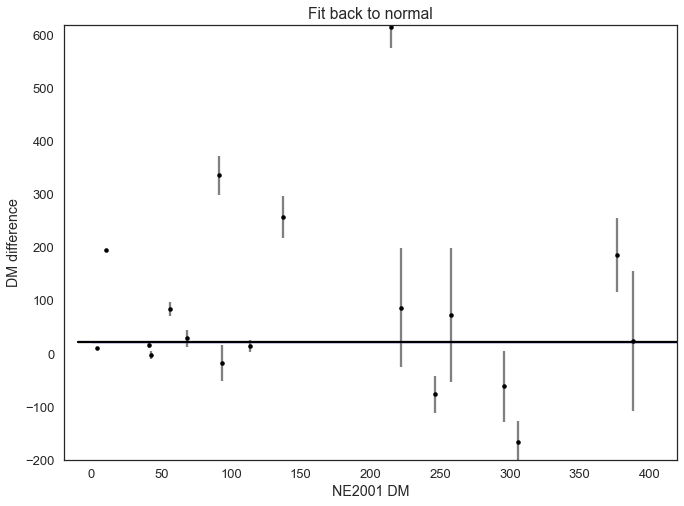

In [43]:
diff = DM_meas - DM_c
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1,1,1)

plt.errorbar(x_matrix[:,0], diff, yerr = avg_e, fmt='.k', ecolor='gray')
plt.xlabel('NE2001 DM')
plt.ylabel('DM difference')
plt.title('Fit back to normal')
plt.plot(xfit, -theta3[0]*np.ones([len(xfit)]) , color='black', label="Bayesian marginalization")

xi = np.arange(0.0, 450, 0.1)
y_up = mean_associated + np.std(sample)
y_down = mean_associated - np.std(sample)
ax.fill_between(xi, y_up, y_down, alpha=0.2, color='blue')#, hatch='/')

plt.xlim(-20,420)
plt.ylim(-200,620)
#plt.semilogx()

# Bayesian fit for symmetric error bars
Here I use average error bars, the same that I use later on in 'normal' fit. 

In [44]:
def log_prior2(theta):
    # no prior as I want to compare this to normal scipy fit.
    if theta[0] <= 0:
        return 0
    else:
        return 0 #-np.inf

def log_likelihood2(theta, x, y, e):
    dy = y[:,0] - theta[0] - x
    
    logL1 = -0.5 * np.log(2 * np.pi * e ** 2) - 0.5 * (dy / e) ** 2


    return np.sum(logL1)

def log_posterior2(theta, x, y, e):

    return log_prior2(theta) + log_likelihood2(theta, x, y, e)

In [45]:
ndim = 1   # number of parameters in the model
nwalkers = 20  # number of MCMC walkers
nburn = 100  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
#np.random.seed(20)
starting_guesses = np.random.random((nwalkers, ndim)) #-20 + 20* np.random.random((nwalkers, ndim))
#print "HIER", starting_guesses

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior2, args=[DM_meas, x_matrix, avg_e])

sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
# To ckeck if any -infinity exist
print "len all", len(sample)
print "len all infinite", len(sample[np.isfinite(sample)])

len all 38000
len all infinite 38000


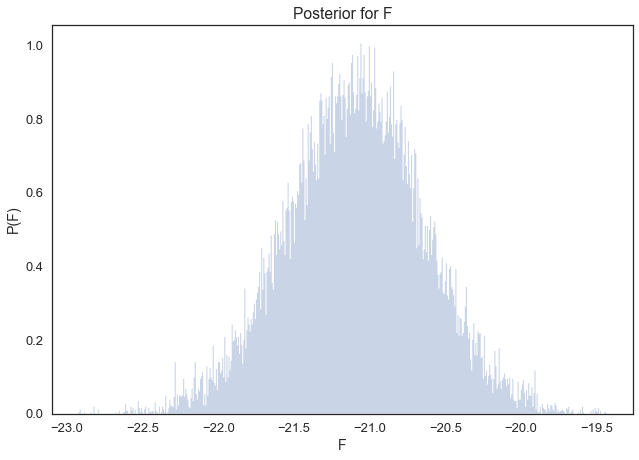

In [46]:
plt.hist(sample, bins=500, histtype="stepfilled", alpha=0.3, normed=True)
#plt.xlabel("theta"); plt.ylabel("PDF")
#F_fit = np.linspace(-23, -19, num=500)
#pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)
#plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")
plt.title('Posterior for F');

# Statistics for Bayesian fit.
Standard deviation is 0.46

In [47]:
# Print the stats
print "Mean is ", np.mean(sample)
print "Standard deviation is ", np.std(sample)

Mean is  -21.0932615112
Standard deviation is  0.455283944585


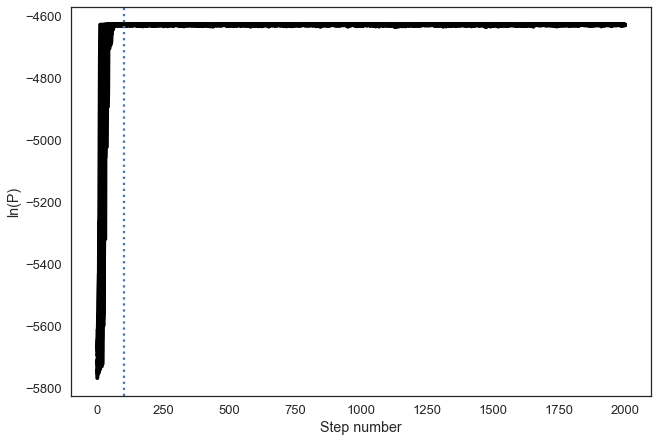

In [48]:
# sampler.lnprobability gives the log probability of the points in tha sampler. THe evolve as follows:

# Let's have a look at all the walkers and a choice of the burn in
for i in range(len(sampler.lnprobability)):
#    print np.amax(sampler.lnprobability[i,1])
    plt.plot(sampler.lnprobability[i,:], linewidth=4, color='k', alpha=1)
plt.ylabel('ln(P)')
plt.xlabel('Step number')
plt.axvline(x=nburn, linestyle='dotted')

# 'Normal' scipy fit with curve_fit from scipy.optimize

In [51]:
# Define function for the fit
def line(x, b):
    return x + b

In [52]:
# Fit the function to the data
def calculate_fit(y, x, avg_e):
    popt, pcov = curve_fit(line, x, y, sigma=avg_e)
    print "NE2001 popt ", popt  # put this in main
    return popt, pcov



In [53]:
# Calculate sigma
def calculate_significance(popt, pcov, s):
    sigma =  pcov[0,0]**0.5
    xi = np.arange(0.0, 1000, 0.1)
    yi = xi + popt[0]
    y_plus = yi + s*sigma
    y_min = yi - s*sigma

    return sigma, y_plus, y_min

In [56]:
def plot_difference():

    DM_meas, DM_low, DM_c, DM_up, sigma_low, sigma_up, age, method, DM_delta, avg_e = coordinates("associated.txt")
    difference_pwn = DM_meas - DM_c

    popt_pwn, pcov_pwn = calculate_fit(DM_meas, DM_c, avg_err)

    sigma_pwn, y_plus_pwn, y_min_pwn = calculate_significance(popt_pwn, pcov_pwn, 1)
    print "sigma pwn = ", sigma_pwn
    ### Plot figure
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(1,1,1)

    plt.errorbar(DM_c, difference_pwn, yerr=avg_e, fmt='v', color='red', label ='PWN + SNR pulsars', linewidth=2) #ASYMMETRIC REAL ERROR

    xfine = np.linspace(0.,450.,900.)
    xi = np.arange(0.0, 450, 0.1)
    print y_plus_pwn
    plt.plot((0,450), (round(popt_pwn[0],2), round(popt_pwn[0],2)), 'k-', color='blue')
    plt.plot((0,450), (0,0), color='black')
    
    y1_up = round(popt_pwn[0],2) + 1 * sigma_pwn
    y1_down = round(popt_pwn[0],2) - 1 * sigma_pwn
    ax.fill_between(xi, y1_up, y1_down, alpha=0.2, color='blue')#, hatch='/')

    ax.set_title('Measured vs. predicted by NE2001 DM', fontsize=20)
    plt.ylabel('DM difference (pc cm$^{-3}$)', fontsize=20)
    plt.xlabel('Expected DM NE2001 (pc cm$^{-3}$)', fontsize=20)
    plt.ylim([-250,700])
    plt.xlim([0,450])
    plt.legend(loc=2)
#    plt.savefig("flat_measured_vs_modeled.pdf", format='pdf')
    plt.show()

# Below do the 'standard' fit. 
I get a standard deviation to the fit of 10.6, plotted in transparent blue. Looking at the spread of the data points this is expected.
Bayesian fit I got 0.46

NE2001 popt  [ 21.06966087]
sigma pwn =  10.5981234081
[   31.66778428    31.76778428    31.86778428 ...,  1031.36778428
  1031.46778428  1031.56778428]


/Users/samayrastraal/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


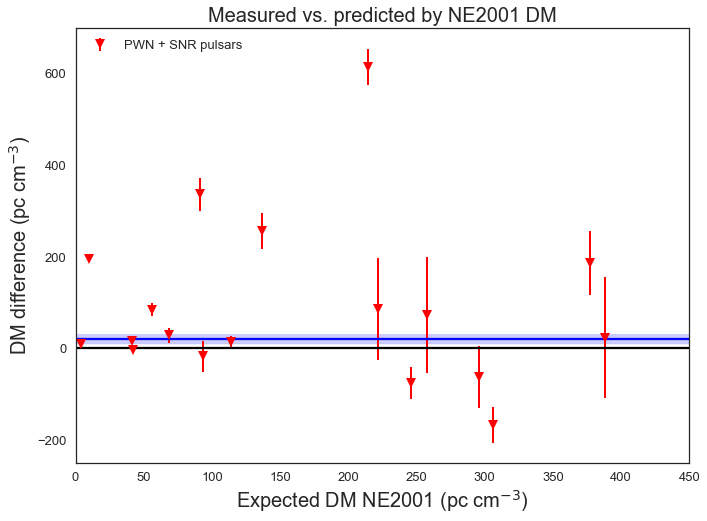

In [57]:
plot_difference()